In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rc

In [73]:

def get_data_list(metric,day,data_source,data_df):
    directory = 'outputs'
    for f in os.listdir(directory):
        if metric in f and day in f and data_source in f:
            df = pd.read_csv(directory+'/'+f,index_col=0)
            
            df = pd.DataFrame(np.abs(df.values),columns=df.columns if len(df.columns)>1 else [metric])
            graph_n = f.replace(metric+'_'+day,'').replace(data_source+'.csv','')
            if graph_n in data_df[data_df.source == data_source].graph.values:
                start_ind = list((data_df.source == data_source) & (data_df.graph == graph_n)).index(True)
                if df.shape[1]>1:
                    for i in range(5):
                        for j in range(5):
                            data_df.iloc[start_ind+j,i+int(metric=='runtimes')*5] = df.iloc[j,i]
                else:
                    for j in range(5):
                        data_df.iloc[start_ind+j,list(data_df.columns).index(metric)] = df.iloc[j,0]
            else:
                df['graph'] = [graph_n]*df.shape[0]
                df['epsilon'] = [1,.8,.6,.4,.2]
                df['source'] = [data_source]*5
                df['day'] = [day]*5
                data_df = data_df.append(df,ignore_index=True)
            
    return data_df



In [272]:
sources = ['citi']
score_cols = ['TRM_scores','Local Ratio_scores', 'HS_scores', 'GHS_scores', 'IHS_scores']
rt_cols = ['TRM_runtimes','Local Ratio_runtimes', 'HS_runtimes',  'GHS_runtimes', 'IHS_runtimes']
df = pd.DataFrame(columns=score_cols+ rt_cols+['graph','epsilon','sdists','source'],)
for metric in ['graphs','runtimes','sdists','scores']:
    for day in ['weekend','weekday']:
        for source in sources:
            df=get_data_list(metric,day,source,df)
for col in score_cols+rt_cols+['epsilon']:
    df[col]=pd.to_numeric(df[col])

In [273]:
def get_det_group(source,day):
    capit_we = df.loc[(df.source==source) & (df.day==day),:].copy()
    df_temp = pd.DataFrame()
    det_cols = []
    for c in score_cols:
        det_col = c.split('_')[0]+'_det'
        det_cols.append(det_col)
        df_temp[det_col] = pd.to_numeric(arg=(capit_we[c].values-capit_we['sdists'].values)/capit_we['sdists'].values)
    df_temp['epsilon'] = capit_we.epsilon.values
    return df_temp, det_cols


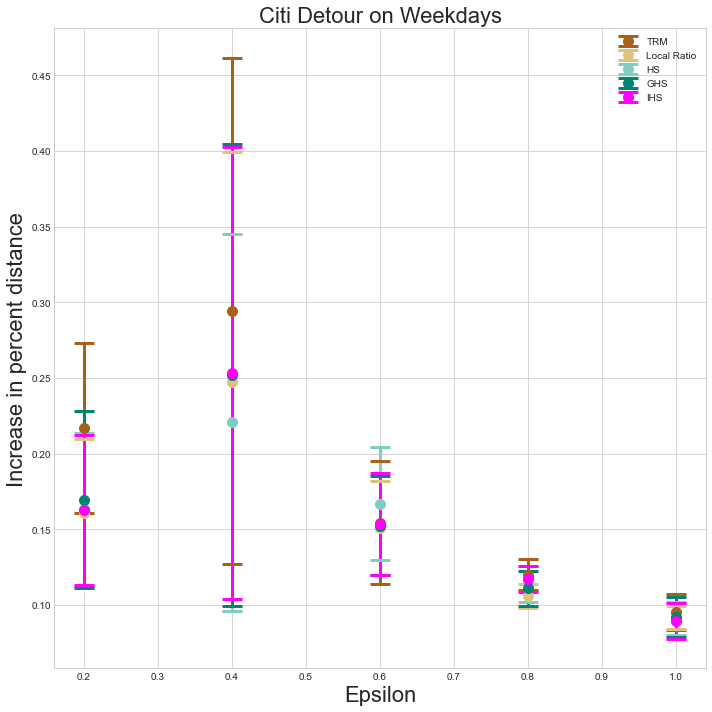

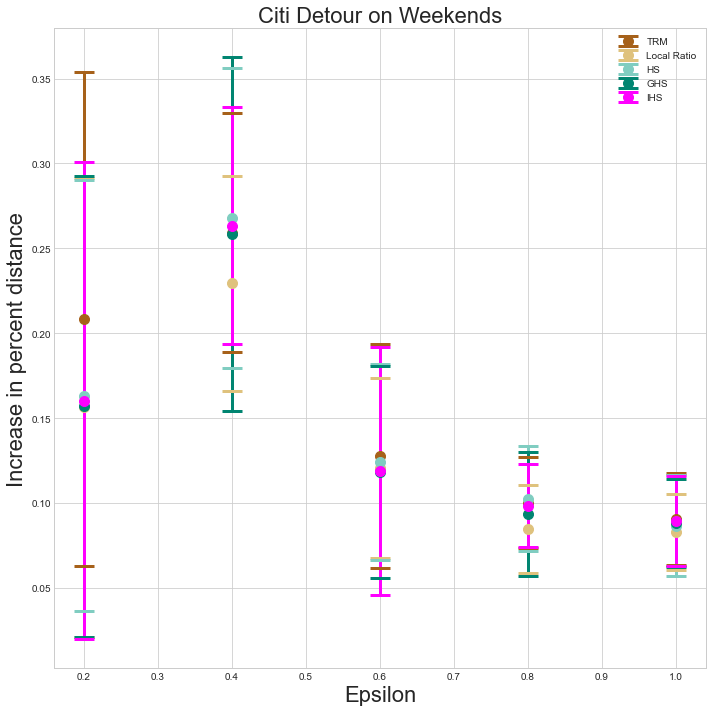

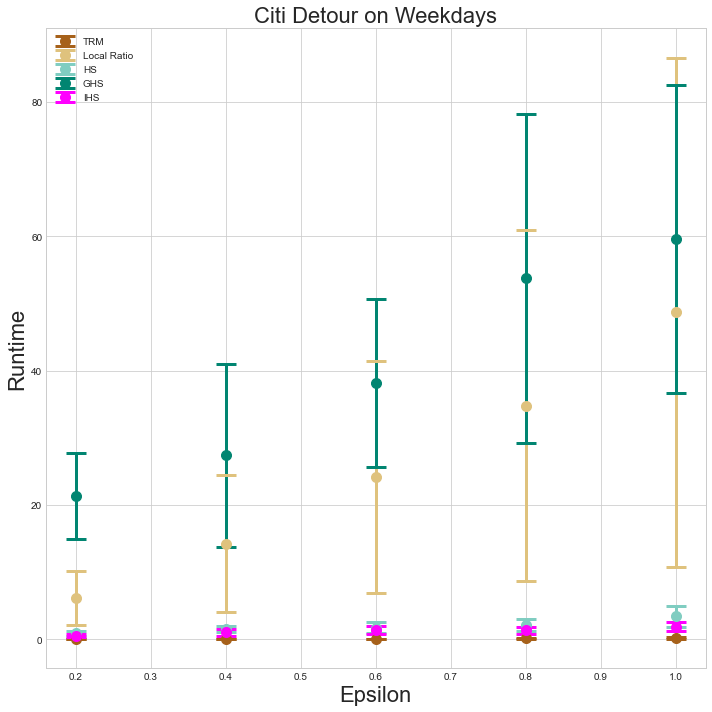

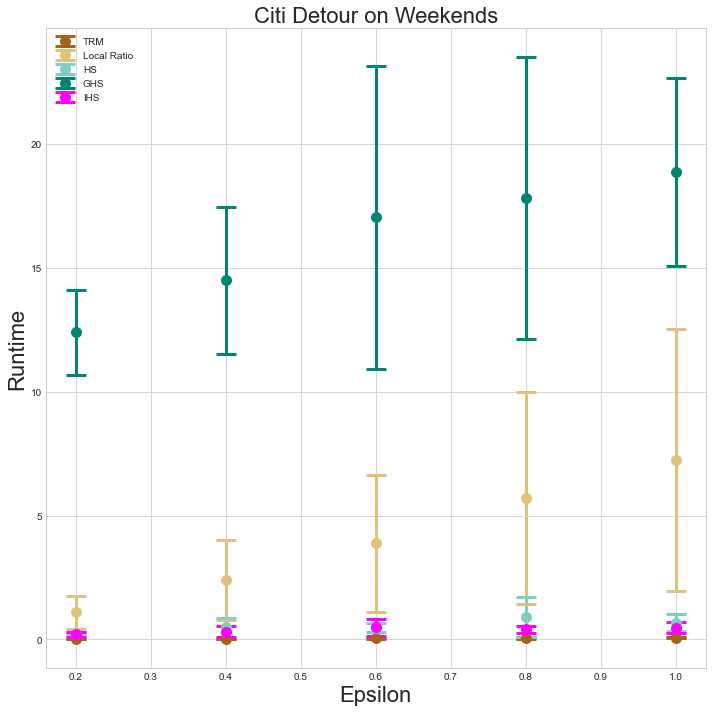

In [253]:
font = {'size'   : 22}
plt.style.use('seaborn-whitegrid')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571','#FF00FF']
color = 0
for source in sources:
    for day in ['weekday','weekend']:
        plt.style.use('seaborn-whitegrid')
        temp_df, det_cols = get_det_group(source,day)
        group = temp_df.groupby('epsilon')
        fig, ax = plt.subplots()
    

        for c in det_cols: 
            ax.errorbar(group.groups.keys(), group[c].mean(), yerr=group[c].std(),label=c.split('_')[0],fmt='o',c=colors[color],ms=10,capsize=10,capthick=3,elinewidth=3)
            color +=1
        color = 0
        plt.title(source.capitalize() +' Detour on '+day.capitalize()+'s',**font)
        plt.legend()
        ax.set_ylabel('Increase in percent distance',**font)
        ax.set_xlabel('Epsilon',**font)
        fig.set_size_inches(10, 10)
        
        fig.tight_layout()
        fig.savefig('figures/'+source+'_'+day+'scores15')
        plt.show()
        
for source in sources:
    for day in ['weekday','weekend']:
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots()
        group = df.loc[(df.source == source) & (df.day==day)].groupby('epsilon')
        for c in rt_cols: 
            ax.errorbar(group.groups.keys(), group[c].mean(), yerr=group[c].std(),label=c.split('_')[0],fmt='o',c=colors[color],ms=10,capsize=10,capthick=3,elinewidth=3)
            color +=1
        color = 0
        plt.title(source.capitalize()+' Detour on '+day.capitalize()+'s',**font)
        ax.set_ylabel('Runtime',**font)
        ax.set_xlabel('Epsilon',**font)
        fig.set_size_inches(10, 10)
        fig.tight_layout()
        plt.legend()
        fig.savefig('figures/'+source+'_'+day+'rt15')
        plt.show()

In [279]:
day='weekday'
latex,det_cols = get_det_group(sources[0],day)
latex = latex.groupby('epsilon').mean()
if len(sources)>1:
    for source in sources[1:]:
        latex.append(df.loc[(df.source == source) & (df.day==day),score_cols+['epsilon']].groupby('epsilon').mean().astype(int))

#for source in sources:
#    latex.append(df.loc[(df.source == source) & (df.day==day),score_cols+['epsilon']].groupby('epsilon').mean().astype(int))

In [280]:
latex

,TRM_det,Local Ratio_det,HS_det,GHS_det,IHS_det
epsilon,,,,,
0.2,0.216959,0.161046,0.163181,0.169645,0.162972
0.4,0.294655,0.247732,0.220929,0.252125,0.253206
0.6,0.154371,0.150837,0.167066,0.152348,0.153516
0.8,0.120026,0.106051,0.113881,0.111200,0.117087
1.0,0.095477,0.091680,0.091009,0.092030,0.089341


In [265]:
df

,TRM_scores,Local Ratio_scores,HS_scores,GHS_scores,IHS_scores,TRM_runtimes,Local Ratio_runtimes,HS_runtimes,GHS_runtimes,IHS_runtimes,graph,epsilon,sdists,source,graphs,day
0,474469.595188,469816.311483,473716.217088,473245.505697,473842.850051,0.097217,10.992220,0.912616,21.560332,0.635675,1,1.0,427610,citi,174.0,weekend
1,380021.456883,374505.091444,381826.565907,380067.845321,378885.199417,0.071572,8.746734,1.488547,21.837698,0.508239,1,0.8,339560,citi,151.0,weekend
2,290291.961907,286203.948034,287873.484864,287253.709779,289316.819798,0.050663,5.844498,0.604468,21.365881,0.740466,1,0.6,247142,citi,128.0,weekend
3,168326.044004,164896.311561,167752.462777,164896.311561,168986.316271,0.031683,3.542832,0.753290,16.605544,0.466540,1,0.4,139184,citi,106.0,weekend
4,92179.278182,88021.474755,88088.502281,88088.502281,88548.795968,0.016191,1.570142,0.279667,13.614794,0.278359,1,0.2,70302,citi,83.0,weekend
5,367250.700778,365705.198552,365306.541121,366701.527862,367074.492541,0.050582,3.491691,0.424322,16.181629,0.307868,2,1.0,342743,citi,127.0,weekend
6,301943.697844,297804.524392,301827.591081,298116.574949,301943.697844,0.038013,2.668735,0.344844,13.803128,0.305957,2,0.8,279253,citi,110.0,weekend
7,220539.233636,220987.186930,220987.186930,219159.125821,217699.109354,0.027338,1.929484,0.338712,12.714737,0.248313,2,0.6,203977,citi,94.0,weekend
8,155233.885067,151106.967869,157724.480566,157942.546378,155666.330615,0.016200,1.251624,0.220908,12.409891,0.149404,2,0.4,118585,citi,77.0,weekend
9,77968.051696,74816.645751,75692.415685,74816.645751,74816.645751,0.008766,0.603523,0.194318,11.198517,0.132973,2,0.2,70513.7,citi,61.0,weekend
